# Functions

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import ndimage
import import_ipynb
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [45]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [46]:
def PIfunc(r, x, v, dt, window):
# PIfunc is a code performing PID on I(r,{x,v}; \detla t) for \detla t in 'window'.
# It returns timeshift and Information,
    # timeshift is time-axis of TLPI;
    # Information is a dictionary, which cotains 4 kinds of PI with one or two proposal.

# r, x, v are three random variables, they are integers.
# dt is the length of the time bin.
# window is a 2-element array, indicating the time-region of interest for TLPI.
# The keyword 'method' decide which proposal for PID would be carried out and exported.
    # The 'method' 'Beer' proposed by Beer et al. (2010). https://arxiv.org/abs/1004.2515.
    # The 'method' 'BROJA_2PID' proposed by Bertschinger et al. (2014). https://dx.doi.org/10.3390/e16042161.
    # There is a function 'BROJA_2PID' for PID part written by Makkeh et al. (2018). https://dx.doi.org/10.3390/e20040271
#     for k, v in kwargs.items():
#         vars()[k] = v
#     if ~('method' in locals()):      method = 'Beer'

    negshift = window[0] # second
    posshift = window[1] # second
    shiftlen = (posshift-negshift)/dt+1
    timeshift = np.linspace(negshift,posshift,int(shiftlen))
    bitshift = np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16') #time-bin-axis of TLPI;
    Information = dict()
    Information[('Beer','Red')]=np.zeros(len(bitshift)) 
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))

    parms = dict() # necessary for 'BROJA_2PID'
    parms['max_iters'] = 20
    for i in range(len(bitshift)):
        # shift '\detla t' between inputs
        # shift>0 => r shifted to positive side
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i] 
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, _ = np.histogramdd(dat, bins=(xedges, vedges, redges)) #3-D Mass Matrix
        #Calculate probability of each set (Density Matrices)
        #All matrices are 3D, x on 0th axis, v on 1st axis, r on 2nd axis
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        
        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt #I(r,x;\detla t)
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt #I(r,v;\detla t)
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt #I(r,{x,v};\detla t)
        # specific surprise 
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1)) #i_s(R=r,X) for all r
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1)) #i_s(R=r,V) for all r
        R = sum(np.minimum(PI_xR, PI_vR))/dt # Redunancy of I(r,{x,v};\detla t)
        Information[('Beer','Red')][i] = R 
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

        # meanFiringRate = np.sum(rr)/(len(rr)*dt)
    Hr = -np.nansum(pr*np.log2(pr))/dt  

    return timeshift, Information, Hr


def PIfunc4ISI(r, x, v, Spike, dt, window, PorP):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
            SS=np.hstack((Spike[:sum(rr)+1],Spike[-1]-timeshift[i]))
        elif shift==0:
            xx=x
            vv=v
            rr=r
            SS=Spike
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
            SS=np.hstack((-timeshift[i],Spike[-sum(rr)-1:]))
        if len(SS)-2 != sum(rr):
            print(timeshift[i], SS[0:2], i)
            print(len(SS), sum(rr))
        new_xx = []
        new_vv = []
        post_ISI,_ = EqualState(np.diff(SS)[1:],cut_state_num)
        pre_ISI,_ = EqualState(np.diff(SS)[:-1],cut_state_num)
        for j in np.squeeze(np.where(rr != 0)):
            for k in range(rr[j]):
                new_xx.append(xx[j])
                new_vv.append(vv[j])
        new_xx = np.array(new_xx)
        new_vv = np.array(new_vv)
        if PorP == 'post':
            new_rr = post_ISI
        elif PorP == 'pre':
            new_rr = pre_ISI
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(new_xx),(max(new_xx)+1))
        vedges = np.append(np.unique(new_vv),(max(new_vv)+1))
        redges = np.append(np.unique(new_rr),(max(new_rr)+1))
        dat = np.concatenate((new_xx[:,np.newaxis], new_vv[:,np.newaxis],new_rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
                        
        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    Hr = -np.nansum(pr*np.log2(pr))/dt  

    return timeshift, Information, Hr

# Load and Set

In [47]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20211029\\SplitData\\'
# channelnumber = 57
exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'
channelnumber = 30

dt = 0.01
global cut_state_num
cut_state_num = 8

for filename in os.listdir(exp_folder):
    # if filename.find('diode_OU_tau=500ms_cutoff=1_mean=10_C=0.2')==-1:
    if filename.find('diode_OU_tau=500ms_cutoff=1_mean=10_amp=2')==-1:
        continue
    print(filename[:-17]+filename[-5])
    annots = loadmat(exp_folder+filename, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x-np.mean(x))/np.std(x)
    T=np.arange(len(x))*dt
    Spike = annots['Spikes'][channelnumber-1]
    Spike = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]

xstate, _= EqualState(x, cut_state_num)
v = ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt
vstate, _= EqualState(v, cut_state_num)

diode_OU_tau=500ms_cutoff=1_mean=10_amp=2_0


# Rate code

In [48]:
rstate, _ = np.histogram(Spike, np.append(T, T[-1]+dt))
timeshift, rateInformation, rateHr = PIfunc(rstate, xstate, vstate, dt, [-1,1])

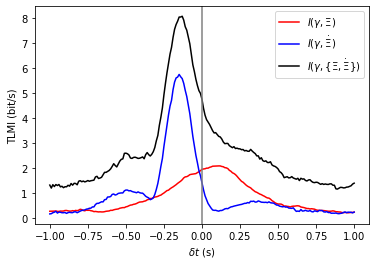

In [49]:
Information = rateInformation
plt.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-', label=r'$I(\gamma,\Xi)$')
plt.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-', label=r'$I(\gamma,\dot\Xi)$')
plt.plot(timeshift, Information[('Beer','UIx')]+Information[('Beer','Red')]
                   +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-', label=r'$I(\gamma,\{\Xi,\dot\Xi\})$')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Rate code ('Binary-Word')

In [50]:
def binaryState(spikeTrain, wordLength, dt, Ttotal):
    rstate,_ = np.histogram(spikeTrain, np.arange(0,Ttotal+1.5*dt,dt/wordLength))
    rstate[rstate>1] = 1
    rstate = rstate[:wordLength*int(len(rstate)/wordLength)]
    _, index = np.unique(rstate.reshape((-1,wordLength)), axis = 0, return_inverse=True)
    return index

In [51]:
wordLength = 3
wordstate = binaryState(Spike, wordLength, dt, T[-1])

In [52]:
timeshift, wordInformation, wordHr = PIfunc(wordstate, xstate, vstate, dt, [-1,1])

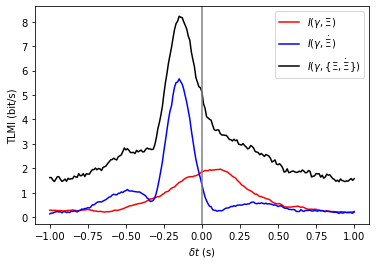

In [53]:
Information = wordInformation
plt.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-', label=r'$I(\gamma,\Xi)$')
plt.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-', label=r'$I(\gamma,\dot\Xi)$')
plt.plot(timeshift, Information[('Beer','UIx')]+Information[('Beer','Red')]
                   +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-', label=r'$I(\gamma,\{\Xi,\dot\Xi\})$')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = bin)

In [54]:
HeadSpikeEnd = np.hstack((0, Spike, T[-1]+dt))
ISI = np.zeros(len(rstate))

counter = 0
for i in range(len(rstate)):
    counter += rstate[i]
    ISI[i] = (HeadSpikeEnd[counter+1]-HeadSpikeEnd[counter-rstate[i]])/(rstate[i]+1)
timestate, _ = EqualState(ISI, cut_state_num)

In [55]:

timeshift, timeInformation, timeHr = PIfunc(timestate, xstate, vstate, dt, [-1,1])

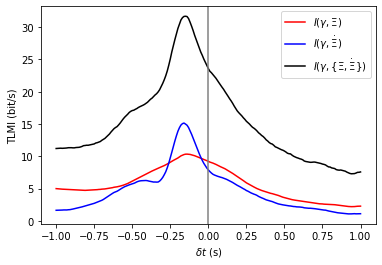

In [56]:
Information = timeInformation
plt.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-', label=r'$I(\gamma,\Xi)$')
plt.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-', label=r'$I(\gamma,\dot\Xi)$')
plt.plot(timeshift, Information[('Beer','UIx')]+Information[('Beer','Red')]
                   +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-', label=r'$I(\gamma,\{\Xi,\dot\Xi\})$')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; pre-ISI)

In [57]:
timeshift, preInformation, preHr = PIfunc4ISI(rstate, xstate, vstate, HeadSpikeEnd, dt, [-1,1], 'pre')

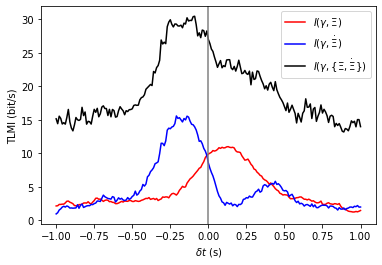

In [58]:
Information = preInformation
plt.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-', label=r'$I(\gamma,\Xi)$')
plt.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-', label=r'$I(\gamma,\dot\Xi)$')
plt.plot(timeshift, Information[('Beer','UIx')]+Information[('Beer','Red')]
                   +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-', label=r'$I(\gamma,\{\Xi,\dot\Xi\})$')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; post-ISI)

In [59]:
timeshift, postInformation, postHr = PIfunc4ISI(rstate, xstate, vstate, HeadSpikeEnd, dt, [-1,1], 'post')

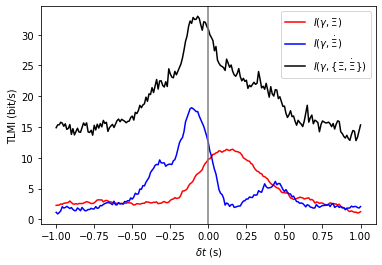

In [60]:
Information = postInformation
plt.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-', label=r'$I(\gamma,\Xi)$')
plt.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-', label=r'$I(\gamma,\dot\Xi)$')
plt.plot(timeshift, Information[('Beer','UIx')]+Information[('Beer','Red')]
                   +Information[('Beer','UIv')]+Information[('Beer','Syn')], 'k-', label=r'$I(\gamma,\{\Xi,\dot\Xi\})$')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Comparasion

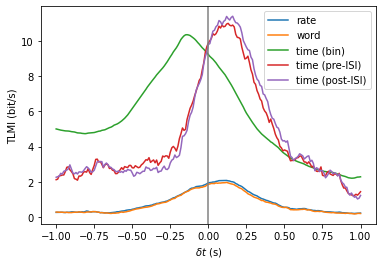

In [61]:
plt.plot(timeshift,rateInformation[('Beer','UIx')]+rateInformation[('Beer','Red')], label='rate')
plt.plot(timeshift,wordInformation[('Beer','UIx')]+wordInformation[('Beer','Red')], label='word')
plt.plot(timeshift,timeInformation[('Beer','UIx')]+timeInformation[('Beer','Red')], label='time (bin)')
plt.plot(timeshift,preInformation[('Beer','UIx')] +preInformation[('Beer','Red')] , label='time (pre-ISI)')
plt.plot(timeshift,postInformation[('Beer','UIx')]+postInformation[('Beer','Red')], label='time (post-ISI)')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

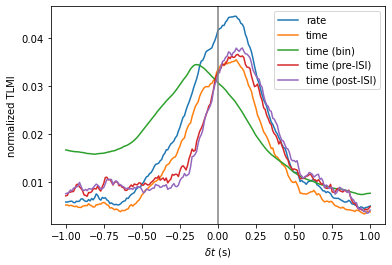

In [62]:
plt.plot(timeshift, (rateInformation[('Beer','UIx')]+rateInformation[('Beer','Red')])/rateHr, label='rate')
plt.plot(timeshift, (wordInformation[('Beer','UIx')]+wordInformation[('Beer','Red')])/wordHr, label='time')
plt.plot(timeshift, (timeInformation[('Beer','UIx')]+timeInformation[('Beer','Red')])/timeHr, label='time (bin)')
plt.plot(timeshift, (preInformation[('Beer','UIx')] +preInformation[('Beer','Red')] )/preHr , label='time (pre-ISI)')
plt.plot(timeshift, (postInformation[('Beer','UIx')]+postInformation[('Beer','Red')])/postHr, label='time (post-ISI)')
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')